In [ ]:
# pip install darts
# pip install lunarcalendar

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

In [3]:
import pickle
with open('../data/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [4]:
coin = data['KRW-BTC'][['candle_date_time_kst', 'trade_price']]
coin.set_index(pd.to_datetime(coin['candle_date_time_kst']), inplace = True)
coin = coin.drop(columns = ['candle_date_time_kst'])
coin = coin[~coin.index.duplicated(keep = 'first')]

In [11]:
coin.shape

(1618, 1)

In [12]:
series = TimeSeries.from_dataframe(coin,  value_cols = 'trade_price', fill_missing_dates=True, freq=None)

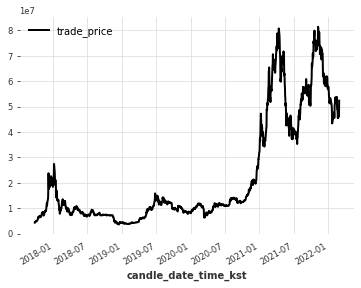

In [13]:
series.plot()

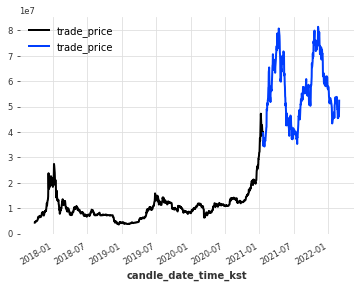

In [15]:
series1, series2 = series.split_before(.75)
series1.plot()
series2.plot()

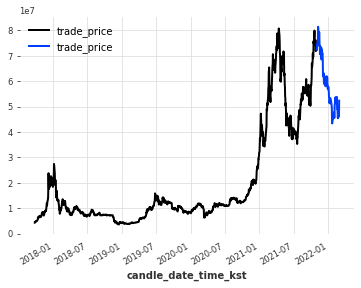

In [16]:
pred_step = 120

series1, series2 = series[:-pred_step], series[-pred_step:]
series1.plot()
series2.plot()

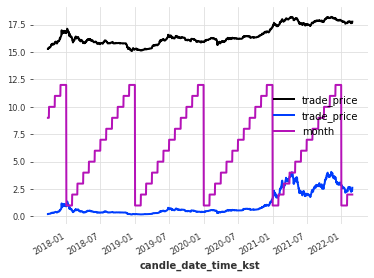

In [17]:
series.map(np.log).plot()
(series/20000000).add_datetime_attribute('month').plot()

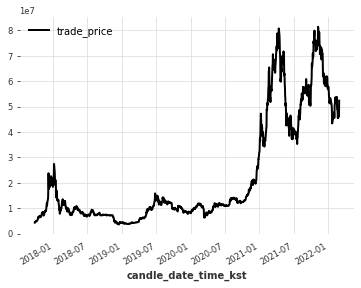

In [18]:
(series).plot()

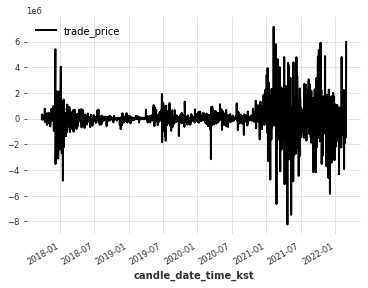

In [19]:
series.diff().plot()

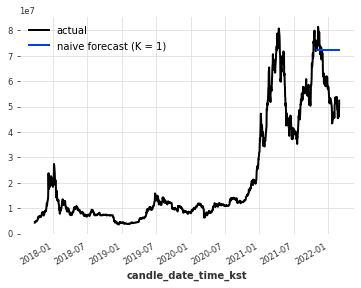

In [20]:
from darts.models import NaiveSeasonal


# train, val = series.split_before(pd.Timestamp('20211001'))
train, val = series[:-pred_step], series[-pred_step:]
naive_model = NaiveSeasonal(K = 1)
naive_model.fit(train)
naive_forecast = naive_model.predict(pred_step)
series.plot(label = 'actual')
naive_forecast.plot(label = 'naive forecast (K = 1)')

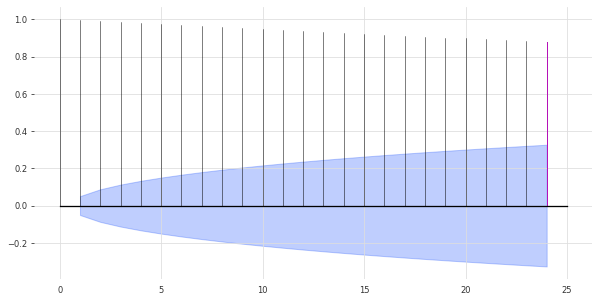

In [21]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m = 24, alpha = .05)

In [22]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m = m, alpha = .05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

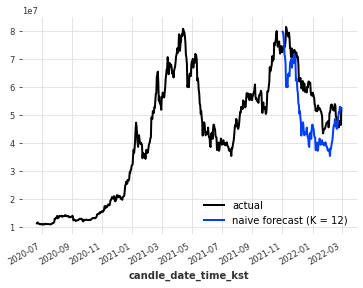

In [28]:
seasonal_model = NaiveSeasonal(K = 200)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(pred_step)

series[1000:].plot(label = 'actual')
seasonal_forecast.plot(label = 'naive forecast (K = 12)')

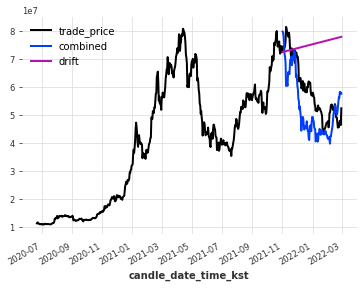

In [29]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(pred_step)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series[1000:].plot()
combined_forecast.plot(label = 'combined')
drift_forecast.plot(label = 'drift')

In [30]:
from darts.metrics import mape
print(f'Mean absolute percentage error for the combined naive drift + seasonal: {round(mape(series, combined_forecast), 2)}%')

Mean absolute percentage error for the combined naive drift + seasonal: 14.04%


In [31]:
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print(f'model {model} obtains MAPE: {round(mape(val, forecast), 2)}')
    
eval_model(ExponentialSmoothing())
eval_model(Prophet(weekly_seasonality = True, daily_seasonality = True))
eval_model(AutoARIMA())
eval_model(Theta())

/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 obtains MAPE: 33.76
model Prophet obtains MAPE: 39.34
model Auto-ARIMA obtains MAPE: 28.06
model Theta(2) obtains MAPE: 29.84


/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [32]:
# Prophet
prop = Prophet(weekly_seasonality = True, daily_seasonality = True)
prop.fit(train)
prop_forecast = prop.predict(len(val))

In [33]:
len(val)

120

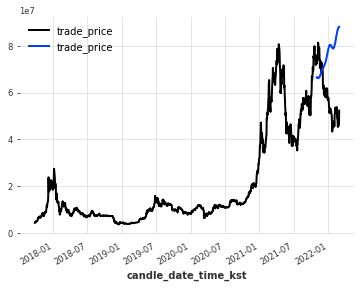

In [34]:
series.plot()
prop_forecast.plot()

## Backtesting

  0%|          | 0/483 [00:00<?, ?it/s]

MAPE = 22.3


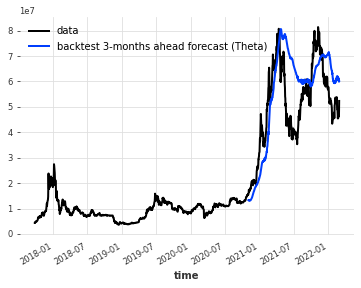

In [39]:
historical_fcast_prop = prop.historical_forecasts(series, start = .7, forecast_horizon = 5, verbose = True)
series.plot(label = 'data')
historical_fcast_prop.plot(label = 'backtest 3-months ahead forecast (Prophet)')
print(f'MAPE = {round(mape(historical_fcast_prop, series), 2)}')

In [41]:
raw_errors = historical_fcast_prop.backtest(series, start = .7, forecast_horizon = 3, metric = mape, reduction = None, verbose = True)

from darts.utils.statistics import plot_hist
plot_hist(raw_errors, bins = np.arange(0, max(raw_errors), 1), title = 'Individual backtest error scores (histogram)',)

AttributeError: 'TimeSeries' object has no attribute 'backtest'

In [152]:
average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

  0%|          | 0/646 [00:00<?, ?it/s]

/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization f

Average error (MAPE) over all historical forecasts: 6.34


/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization f

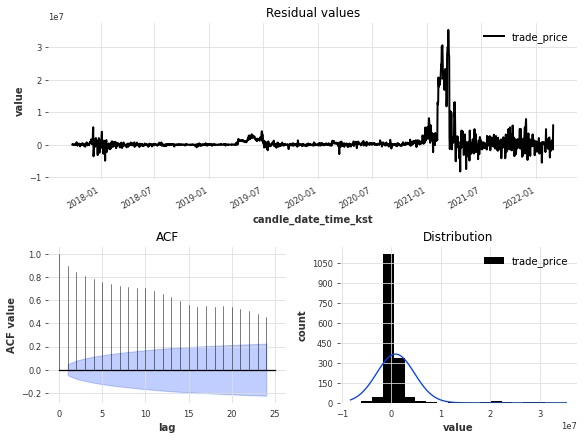

In [153]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))

  0%|          | 0/646 [00:00<?, ?it/s]

/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization f

MAPE = 5


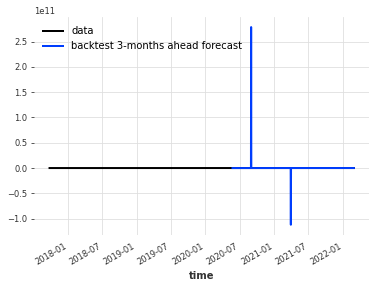

In [154]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(series, start = .6, forecast_horizon = 3, verbose = True)
series.plot(label = 'data')
historical_fcast_es.plot(label = 'backtest 3-months ahead forecast')
print(f'MAPE = {round(mape(historical_fcast_es, series))}')

In [155]:
plot_residuals_analysis(model_es.residuals(series))

/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/kyle/.pyenv/versions/3.8.3/envs/image_crawler/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization f

KeyboardInterrupt: 